In [1]:
import numpy as np
from dataclasses import dataclass


def saturate(val: float, min: float, max: float) -> float:
    if val > max:
        val = 1
    elif val < min:
        val = 0
    return val


def naive_power(energy: float, time: float, timebase=1) -> float:
    """energy [Wh], time [h|s], use timebase=1 if time in hours, or timebase=3600 if time in seconds"""
    return np.divide(energy, time / timebase)


def naive_energy(power: float, time: float, timebase=1) -> float:
    """power [W], time [h|s], use timebase=1 if time in hours, or timebase=3600 if time in seconds"""
    return power * (time / timebase)


@dataclass
class Panel:
    efficiency: float
    maximum_power: float

    def run(self, irradiation: float) -> float:
        irradiation = saturate(irradiation, 0, 1)

        output_power = irradiation * self.maximum_power
        if output_power > self.maximum_power:
            output_power = self.maximum_power
        output_power = output_power * self.efficiency
        return output_power


@dataclass
class Motor:
    maximum_power: float

    def run(self, throttle: float) -> float:
        throttle = saturate(throttle, 0, 1)

        input_power = throttle * self.maximum_power
        if input_power > self.maximum_power:
            input_power = self.maximum_power
        return input_power


@dataclass(init=False)
class Battery:
    efficiency: float
    energy: float
    soc: float
    minimum_soc: float
    maximum_energy: float
    minimum_energy: float
    maximum_power: float

    def __init__(
        self,
        soc_0: float,
        minimum_soc: float,
        efficiency: float,
        maximum_energy: float,
        maximum_power: float,
    ):
        self.efficiency = efficiency
        self.soc = soc_0
        self.minimum_soc = minimum_soc
        self.energy = soc_0 * maximum_energy
        self.maximum_energy = maximum_energy
        self.minimum_energy = maximum_energy * minimum_soc
        self.maximum_power = maximum_power

    def _charge(self, dt: float, power: float) -> float:
        energy = naive_energy(power, dt)
        self.energy += energy * self.efficiency

        if self.energy > self.maximum_energy:
            exceeded_energy = self.energy - self.maximum_energy
            self.energy -= exceeded_energy
            exceeded_power = naive_power(exceeded_energy, dt)
            return power - exceeded_power

        return power

    def _discharge(self, dt: float, power: float) -> float:
        energy = naive_energy(power, dt)
        self.energy -= energy * self.efficiency

        if self.energy < self.minimum_energy:
            exceeded_energy = self.minimum_energy - self.energy
            self.energy += exceeded_energy
            exceeded_power = naive_power(exceeded_energy, dt)
            return power - exceeded_power

        return power

    def run(self, dt: float, target_power: float) -> float:
        power = 0
        if target_power > 0:
            power = self._charge(dt, abs(target_power))
        else:
            power = -self._discharge(dt, abs(target_power))

        self.soc = self.energy / self.maximum_energy
        return power


@dataclass
class Other:
    power: float


@dataclass
class Boat:
    panel: Panel
    motor: Motor
    battery: Battery
    circuits: Other

    def run(self, dt: float, irradiation: float, motor_throttle: float):
        # TODO: Create exeption types and throw then in case of battery under or over voltage. This battery exception might be implemented as a BMS model, which could be disabled.
        # TODO: Create some way to programatically inject an exception, to simulate catastrophic events like crashes, which could take the boat off the race.

        # Step #1 - solve for battery:
        target_circuits_power = self.circuits.power
        target_pv_power = self.panel.run(irradiation)
        target_motor_power = self.motor.run(motor_throttle)
        target_battery_power = (
            target_pv_power - target_motor_power - target_circuits_power
        )
        actual_battery_power = self.battery.run(dt, target_battery_power)

        # Step #2 - solve for base circuits
        # if target_circuits_power > actual_battery_power:
        #     raise Exception("There is no power to keep the basic boat's circuits running!")
        actual_circuits_power = target_circuits_power

        # Step #3 - solve for pv:
        actual_pv_power = (
            actual_battery_power + target_motor_power + actual_circuits_power
        )
        if actual_pv_power > target_pv_power:
            actual_pv_power = target_pv_power

        # Step #4 - solve for motor:
        actual_motor_power = (
            actual_pv_power - actual_battery_power - actual_circuits_power
        )
        if actual_motor_power > target_motor_power:
            actual_motor_power = target_motor_power

        return (
            self.battery.soc,
            actual_pv_power,
            actual_motor_power,
            actual_battery_power,
            target_pv_power,
            target_motor_power,
            target_battery_power,
        )


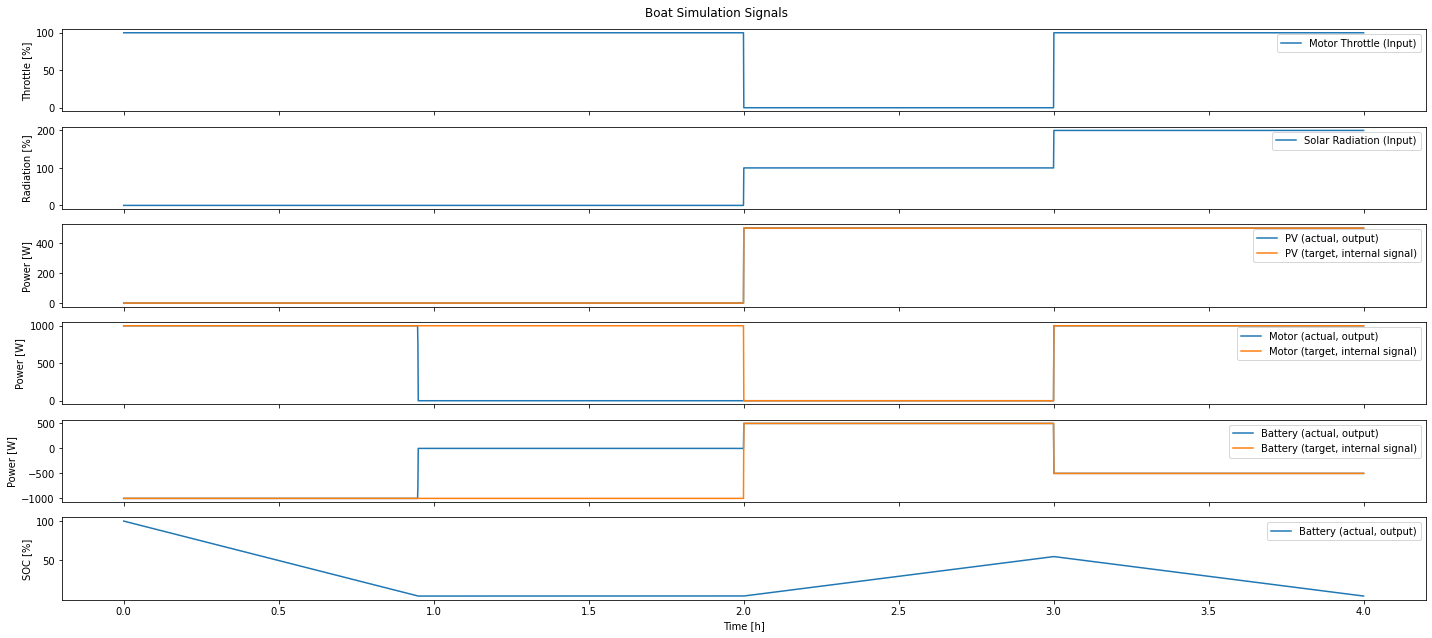

In [2]:
boat = Boat(
    panel=Panel(efficiency=1, maximum_power=500),
    motor=Motor(maximum_power=1000),
    battery=Battery(
        efficiency=1,
        soc_0=1,
        minimum_soc=0.05,
        maximum_energy=1000,
        maximum_power=10000,
    ),
    circuits=Other(power=0),
)

t = np.linspace(0, 4, 3600, endpoint=True)
pv_tar_radiation = np.array(
    ([0.0] * (t.size // 4))
    + ([0.0] * (t.size // 4))
    + ([1.0] * (t.size // 4))
    + ([2.0] * (t.size // 4)),
    dtype=float,
)
motor_tar_throttle = np.array(
    ([1.0] * (t.size // 4))
    + ([1.0] * (t.size // 4))
    + ([0.0] * (t.size // 4))
    + ([1.0] * (t.size // 4)),
    dtype=float,
)

battery_out_energy = np.zeros(t.size)
pv_out_power = np.zeros(t.size)
motor_out_power = np.zeros(t.size)
battery_out_power = np.zeros(t.size)
pv_tar_power = np.zeros(t.size)
motor_tar_power = np.zeros(t.size)
battery_tar_power = np.zeros(t.size)

dt = t[1] - t[0]

for k in range(t.size):
    y = boat.run(dt, pv_tar_radiation[k], motor_tar_throttle[k])

    battery_out_energy[k] = y[0]
    pv_out_power[k] = y[1]
    motor_out_power[k] = y[2]
    battery_out_power[k] = y[3]
    pv_tar_power[k] = y[4]
    motor_tar_power[k] = y[5]
    battery_tar_power[k] = y[6]


import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, figsize=(20, 6 * 1.5), sharex=True, sharey=False)

axs[0].plot(t, motor_tar_throttle * 100, label="Motor Throttle (Input)")
axs[0].legend(loc="upper right")
axs[0].set_ylabel("Throttle [%]")

axs[1].plot(t, pv_tar_radiation * 100, label="Solar Radiation (Input)")
axs[1].legend(loc="upper right")
axs[1].set_ylabel("Radiation [%]")

axs[2].plot(t, pv_out_power, label="PV (actual, output)")
axs[2].plot(t, pv_tar_power, label="PV (target, internal signal)")
axs[2].legend(loc="upper right")
axs[2].set_ylabel("Power [W]")

axs[3].plot(t, motor_out_power, label="Motor (actual, output)")
axs[3].plot(t, motor_tar_power, label="Motor (target, internal signal)")
axs[3].legend(loc="upper right")
axs[3].set_ylabel("Power [W]")

axs[4].plot(t, battery_out_power, label="Battery (actual, output)")
axs[4].plot(t, battery_tar_power, label="Battery (target, internal signal)")
axs[4].legend(loc="upper right")
axs[4].set_ylabel("Power [W]")

axs[5].plot(t, battery_out_energy * 100, label="Battery (actual, output)")
axs[5].legend(loc="upper right")
axs[5].set_ylabel("SOC [%]")

plt.xlabel("Time [h]")
plt.suptitle("Boat Simulation Signals")
plt.tight_layout()
plt.show()
